# 📈 Stock Price Prediction with LSTM

modules used-

- Python Standard: numpy, pandas, os, datetime

- Data Fetching: yfinance

- Data Preprocessing: scikit-learn (MinMaxScaler, LinearRegression, mean_squared_error)

- Deep Learning: tensorflow.keras (Sequential, LSTM, Dense, Dropout, EarlyStopping, ReduceLROnPlateau)

- Visualization: matplotlib.pyplot


## 1) Setup (Run in Google Colab)
If you're running this in **Google Colab**, just run the next cell to install dependencies.
If you're running locally, create a virtual environment and `pip install -r requirements.txt`.


In [1]:
# If running in Colab, uncomment to install
# !pip -q install yfinance tensorflow scikit-learn matplotlib pandas numpy

## 2) Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression  # for a simple baseline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import yfinance as yf

# Matplotlib default settings (no specific style/colors per instruction)
plt.rcParams['figure.figsize'] = (10, 5)


## 3) Configuration

In [3]:
# --- Config ---
TICKER = "TSLA"                 # Change to any ticker, e.g., 'AAPL', 'TCS.NS'
START_DATE = "2018-01-01"
END_DATE   = "2024-12-31"

SEQ_LEN = 60        # Lookback window (days)
TEST_SIZE = 0.2     # 20% test split
EPOCHS = 20
BATCH_SIZE = 32


## 4) Load & Inspect Data

/tmp/ipython-input-2867902383.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2018-01-02,21.368668,21.474001,20.733334,20.799999,65283000
2018-01-03,21.150000,21.683332,21.036667,21.400000,67822500
2018-01-04,20.974667,21.236668,20.378668,20.858000,149194500
2018-01-05,21.105333,21.149332,20.799999,21.108000,68868000
2018-01-08,22.427334,22.468000,21.033333,21.066668,147891000


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2024-12-23,430.600006,434.510010,415.410004,431.000000,72698100
2024-12-24,462.279999,462.779999,435.140015,435.899994,59551800
2024-12-26,454.130005,465.329987,451.019989,465.160004,76366400
2024-12-27,431.660004,450.000000,426.500000,449.519989,82666800
2024-12-30,417.410004,427.000000,415.750000,419.399994,64941000


Rows: 1760


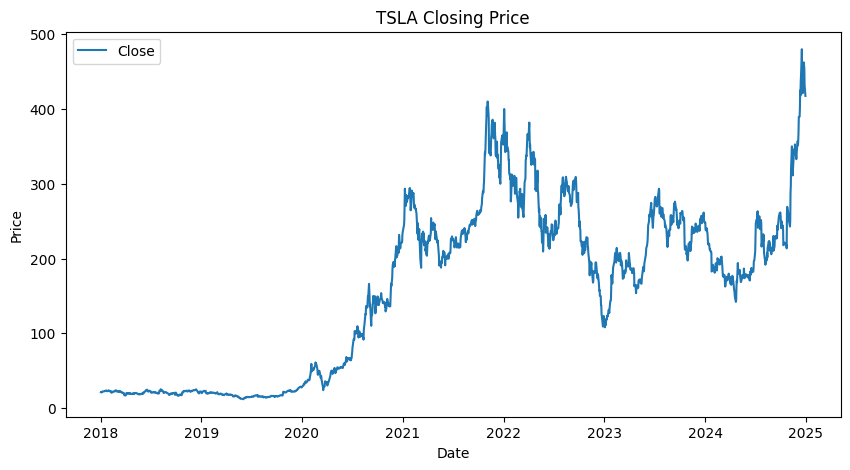

In [4]:
# Fetch OHLCV data
data = yf.download(TICKER, start=START_DATE, end=END_DATE)
if data.empty:
    raise ValueError("No data downloaded. Check ticker or date range.")

display(data.head())
display(data.tail())
print("Rows:", len(data))

# Quick plot of Close prices
plt.plot(data.index, data['Close'], label='Close')
plt.title(f"{TICKER} Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


## 5) Preprocess & Create Sequences

In [5]:
# Use only the 'Close' column for a first-cut model
close_prices = data[['Close']].values

# Scale to [0,1] for LSTM stability
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(close_prices)

def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(seq_len, len(series)):
        X.append(series[i-seq_len:i, 0])
        y.append(series[i, 0])
    X, y = np.array(X), np.array(y)
    # Reshape for LSTM: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequences(scaled, SEQ_LEN)

split_idx = int((1 - TEST_SIZE) * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X.shape, X_train.shape, X_test.shape


((1700, 60, 1), (1360, 60, 1), (340, 60, 1))

## 6) Baseline Models

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Naive baseline
y_pred_naive = X_test[:, -1, 0]
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
y_pred_naive_inv = scaler.inverse_transform(y_pred_naive.reshape(-1,1)).ravel()

# Compute RMSE manually
rmse_naive = np.sqrt(mean_squared_error(y_test_inv, y_pred_naive_inv))
mape_naive = np.mean(np.abs((y_test_inv - y_pred_naive_inv) / y_test_inv)) * 100

print(f"Naive baseline → RMSE: {rmse_naive:.3f}, MAPE: {mape_naive:.2f}%")

# Linear Regression baseline
X_train_flat = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_flat  = X_test.reshape((X_test.shape[0], X_test.shape[1]))

from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train_flat, y_train)

y_pred_lr = linreg.predict(X_test_flat)
y_pred_lr_inv = scaler.inverse_transform(y_pred_lr.reshape(-1,1)).ravel()

rmse_lr = np.sqrt(mean_squared_error(y_test_inv, y_pred_lr_inv))
mape_lr = np.mean(np.abs((y_test_inv - y_pred_lr_inv) / y_test_inv)) * 100

print(f"Linear Regression baseline → RMSE: {rmse_lr:.3f}, MAPE: {mape_lr:.2f}%")



Naive baseline → RMSE: 9.279, MAPE: 2.66%
Linear Regression baseline → RMSE: 9.652, MAPE: 2.93%


## 7) Build & Train the LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0348 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0031 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0024 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0021 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0022 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0023 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0015 - val_loss: 0.0022 - learning_rate: 5.0000e-04
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0014 - val_loss: 0.0019 - learning_rate: 5.0000e-04
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0017 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 1

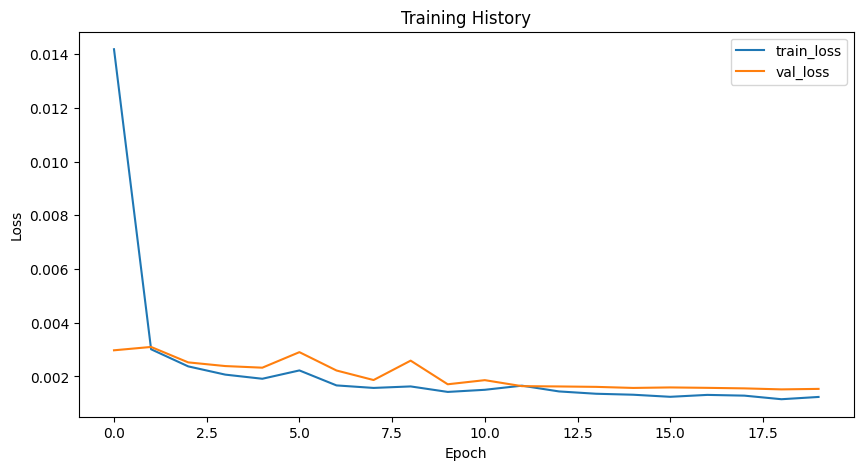

In [10]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## 8) Evaluate & Visualize Results

LSTM → RMSE: 18.242, MAPE: 5.60%


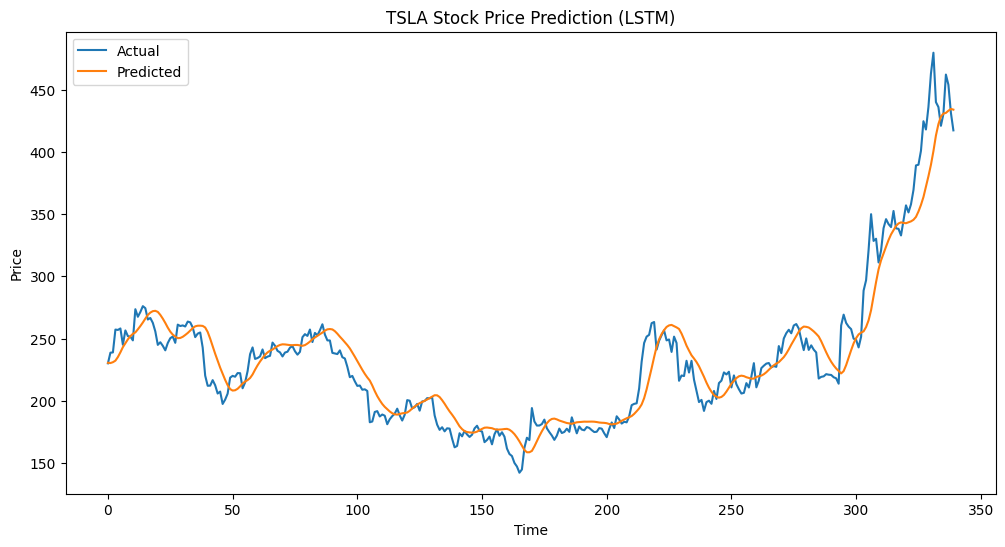

In [12]:
# =========================
# 7) LSTM Evaluation
# =========================

# y_pred: predictions from your trained LSTM
# Example: y_pred = model.predict(X_test)

# Inverse scale predictions
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).ravel()
y_test_inv  = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

# Compute RMSE manually
import numpy as np
from sklearn.metrics import mean_squared_error

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape_lstm = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"LSTM → RMSE: {rmse_lstm:.3f}, MAPE: {mape_lstm:.2f}%")

# Optional: plot actual vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title(f"{TICKER} Stock Price Prediction (LSTM)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
